In [108]:
import networkx as nx

# Create a graph to represent the network
G = nx.DiGraph()

# Add nodes representing physical nodes (e.g., switches, servers)
nodes = ['A', 'B', 'C', 'D', 'E', 'F']
G.add_nodes_from(nodes)

# Add edges with latency (ms) and bandwidth capacity (Mbps) based on examples from manuscripts
edges = [
    ('A', 'B', {'latency': 10, 'capacity': 100}),
    ('A', 'C', {'latency': 15, 'capacity': 50}),
    ('B', 'D', {'latency': 5, 'capacity': 100}),
    ('C', 'D', {'latency': 10, 'capacity': 80}),
    ('C', 'E', {'latency': 20, 'capacity': 30}),
    ('D', 'F', {'latency': 10, 'capacity': 90}),
    ('E', 'F', {'latency': 5, 'capacity': 50})
]

# Add all edges to the graph
G.add_edges_from(edges)

# Store the graph for routing experiments
G_data = [(u, v, G[u][v]) for u, v in G.edges()]

import pandas as pd
df = pd.DataFrame(G_data, columns=['From', 'To', 'Attributes'])
df[['Latency (ms)', 'Capacity (Mbps)']] = df['Attributes'].apply(pd.Series)
df.drop(columns='Attributes', inplace=True)

print(df.to_string(index=False))


From To  Latency (ms)  Capacity (Mbps)
   A  B            10              100
   A  C            15               50
   B  D             5              100
   C  D            10               80
   C  E            20               30
   D  F            10               90
   E  F             5               50


/tmp/ipykernel_916/632968347.py:15: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


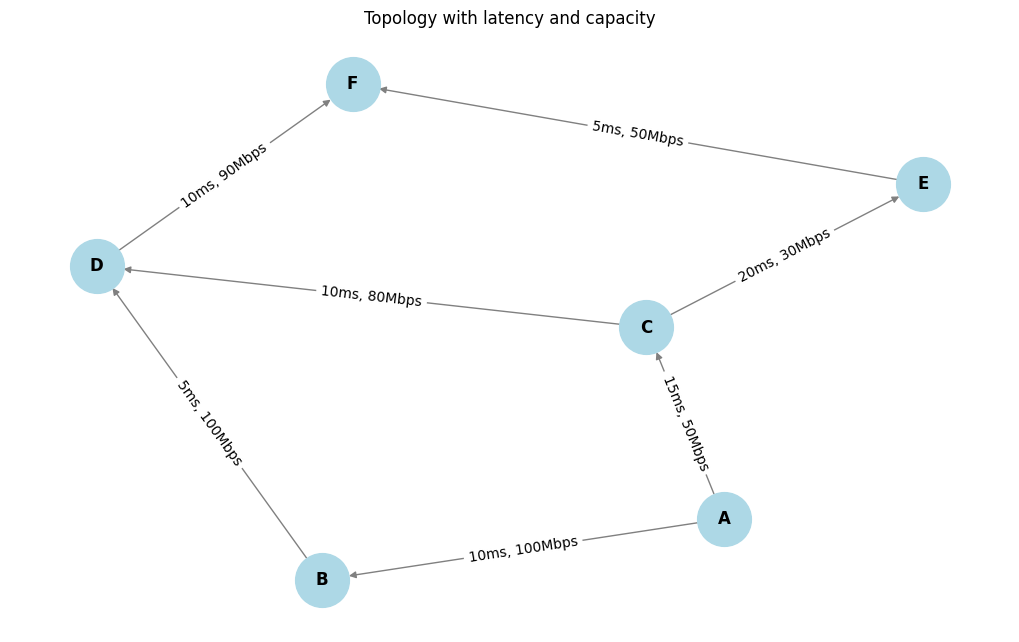

In [109]:
import matplotlib.pyplot as plt

# Draw the graph with labels for latency and capacity
pos = nx.spring_layout(G, seed=42)  # positions for nodes

plt.figure(figsize=(10, 6))
nx.draw(G, pos, with_labels=True, node_color='lightblue', node_size=1500, edge_color='gray', font_size=12, font_weight='bold')

# Draw edge labels with latency and capacity
edge_labels = {(u, v): f"{G[u][v]['latency']}ms, {G[u][v]['capacity']}Mbps" for u, v in G.edges()}
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='black', font_size=10)

plt.title("Topology with latency and capacity")
plt.axis('off')
plt.tight_layout()
plt.show()


In [150]:
# Define source, target, and SLA constraints
source = 'A'
target = 'F'
sla_latency_max = 40  # in milliseconds
sla_min_capacity = 50  # in Mbps

# Heuristic cost function: minimum latency from the current node to any successor
def heuristic(u, v):
    # Simple heuristic: assumes the cost is proportional to the minimum latency among successors
    return min(G[u][n]['latency'] for n in G.successors(u)) if list(G.successors(u)) else 0

# Define cost function based on latency
def cost(u, v):
    return G[u][v]['latency']

# A* algorithm considering link capacity and latency constraints
def astar_with_sla(graph, source, target, sla_min_capacity, sla_latency_max):
    from queue import PriorityQueue
    visited = set()
    queue = PriorityQueue()
    queue.put((0, 0, [source]))  # (priority, accumulated_latency, path)

    while not queue.empty():
        _, total_latency, path = queue.get()
        current = path[-1]

        # If the destination is reached and latency is within SLA, return the path
        if current == target and total_latency <= sla_latency_max:
            return path, total_latency

        if current in visited:
            continue
        visited.add(current)

        for neighbor in graph.successors(current):
            edge = graph[current][neighbor]
            # Only consider links that satisfy the minimum capacity requirement
            if edge['capacity'] >= sla_min_capacity:
                new_latency = total_latency + edge['latency']
                # Only continue exploring if accumulated latency is within SLA
                if new_latency <= sla_latency_max:
                    priority = new_latency + heuristic(neighbor, target)
                    queue.put((priority, new_latency, path + [neighbor]))

    return None, None  # No valid path found

# Run A* with SLA constraints
best_path, total_latency = astar_with_sla(G, source, target, sla_min_capacity, sla_latency_max)
best_path, total_latency


(['A', 'B', 'D', 'F'], 25)

/tmp/ipykernel_916/2455032259.py:26: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


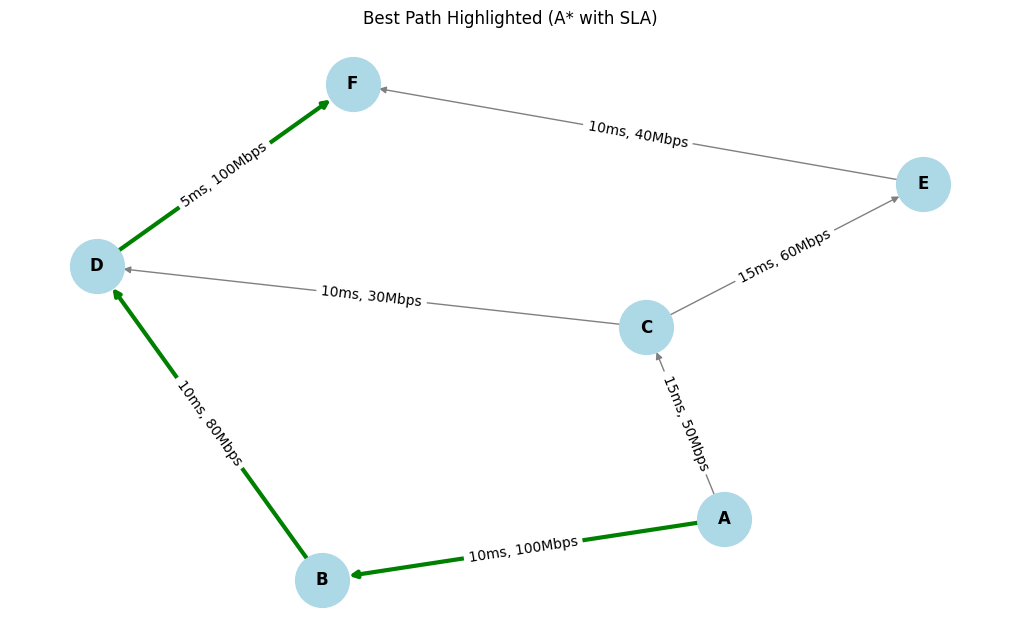

In [151]:
# Draw the graph again, highlighting the best path found

# Define edge colors and widths based on whether they are in the best path
edge_colors = []
edge_widths = []
for u, v in G.edges():
    if best_path and (u, v) in zip(best_path, best_path[1:]):
        edge_colors.append('green')  # Highlight the best path in green
        edge_widths.append(3)
    else:
        edge_colors.append('gray')
        edge_widths.append(1)

plt.figure(figsize=(10, 6))

# Draw the basic graph structure
nx.draw(G, pos, with_labels=True, node_color='lightblue', node_size=1500, 
        edge_color=edge_colors, width=edge_widths, font_size=12, font_weight='bold')

# Annotate edges with latency and capacity information
edge_labels = {(u, v): f"{G[u][v]['latency']}ms, {G[u][v]['capacity']}Mbps" for u, v in G.edges()}
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='black', font_size=10)

plt.title("Best Path Highlighted (A* with SLA)")
plt.axis('off')
plt.tight_layout()
plt.show()


In [152]:
from routing_a_star import astar_with_sla

# Define a reusable function to execute A* routing for multiple slices with SLA constraints
def route_multiple_slices(graph, slice_requests):
    results = []

    # Iterate over each slice request and apply the A* algorithm
    for idx, request in enumerate(slice_requests):
        source = request['source']
        target = request['target']
        sla_latency_max = request['sla_latency']
        sla_min_capacity = request['sla_capacity']

        path, latency = astar_with_sla(graph, source, target, sla_min_capacity, sla_latency_max)
        result = {
            'Slice ID': idx + 1,
            'Source': source,
            'Target': target,
            'SLA Latency Max (ms)': sla_latency_max,
            'SLA Min Capacity (Mbps)': sla_min_capacity,
            'Path Found': path,
            'Total Latency (ms)': latency,
            'SLA Met': path is not None
        }
        results.append(result)

    return pd.DataFrame(results)

# Define example slice requests with varying SLA constraints
slice_requests = [
    {'source': 'A', 'target': 'F', 'sla_latency': 40, 'sla_capacity': 50},
    {'source': 'A', 'target': 'F', 'sla_latency': 20, 'sla_capacity': 80},
    {'source': 'A', 'target': 'F', 'sla_latency': 50, 'sla_capacity': 100},
    {'source': 'C', 'target': 'F', 'sla_latency': 25, 'sla_capacity': 40},
    {'source': 'B', 'target': 'F', 'sla_latency': 15, 'sla_capacity': 90},
]

# Execute routing for the defined slice requests
multi_slice_results = route_multiple_slices(G, slice_requests)
multi_slice_results


,Slice ID,Source,Target,SLA Latency Max (ms),SLA Min Capacity (Mbps),Path Found,Total Latency (ms),SLA Met
0,1,A,F,40,50,"[A, B, D, F]",25.0,True
1,2,A,F,20,80,None,NaN,False
2,3,A,F,50,100,None,NaN,False
3,4,C,F,25,40,"[C, E, F]",25.0,True
4,5,B,F,15,90,None,NaN,False


In [153]:
import random

# Define maximum VNF slots per node
vnf_capacity_per_node = {node: 2 for node in G.nodes}  # Each node can host 2 VNFs

# Track current usage of VNF slots
vnf_allocations = {node: 0 for node in G.nodes}

# Extend slice requests to include number of VNFs (random between 1 and 3 for this example)
for request in slice_requests:
    request['num_vnfs'] = random.randint(1, 3)

# Function to allocate VNFs along the routing path
def allocate_vnfs_on_path(path, num_vnfs):
    allocated_vnfs = []
    for node in path:
        available_slots = vnf_capacity_per_node[node] - vnf_allocations[node]
        if available_slots > 0:
            to_allocate = min(available_slots, num_vnfs - len(allocated_vnfs))
            vnf_allocations[node] += to_allocate
            allocated_vnfs.extend([node] * to_allocate)
        if len(allocated_vnfs) == num_vnfs:
            break
    return allocated_vnfs if len(allocated_vnfs) == num_vnfs else None

# Execute routing and VNF allocation
allocation_results = []

for idx, request in enumerate(slice_requests):
    source = request['source']
    target = request['target']
    sla_latency_max = request['sla_latency']
    sla_min_capacity = request['sla_capacity']
    num_vnfs = request['num_vnfs']

    path, latency = astar_with_sla(G, source, target, sla_min_capacity, sla_latency_max)
    if path:
        vnf_nodes = allocate_vnfs_on_path(path[1:], num_vnfs)  # Skip source for VNF placement
        if vnf_nodes:
            allocation_results.append({
                'Slice ID': idx + 1,
                'Source': source,
                'Target': target,
                'Path': path,
                'Total Latency (ms)': latency,
                'VNFs Required': num_vnfs,
                'VNF Placement': vnf_nodes,
                'SLA Met': True
            })
        else:
            allocation_results.append({
                'Slice ID': idx + 1,
                'Source': source,
                'Target': target,
                'Path': path,
                'Total Latency (ms)': latency,
                'VNFs Required': num_vnfs,
                'VNF Placement': None,
                'SLA Met': False  # Could not place VNFs
            })
    else:
        allocation_results.append({
            'Slice ID': idx + 1,
            'Source': source,
            'Target': target,
            'Path': None,
            'Total Latency (ms)': None,
            'VNFs Required': num_vnfs,
            'VNF Placement': None,
            'SLA Met': False
        })

# Display results
vnf_allocation_df = pd.DataFrame(allocation_results)
vnf_allocation_df


,Slice ID,Source,Target,Path,Total Latency (ms),VNFs Required,VNF Placement,SLA Met
0,1,A,F,"[A, B, D, F]",25.0,1,[B],True
1,2,A,F,None,NaN,3,None,False
2,3,A,F,None,NaN,1,None,False
3,4,C,F,"[C, E, F]",25.0,2,"[E, E]",True
4,5,B,F,None,NaN,2,None,False


/tmp/ipykernel_916/1347019308.py:40: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


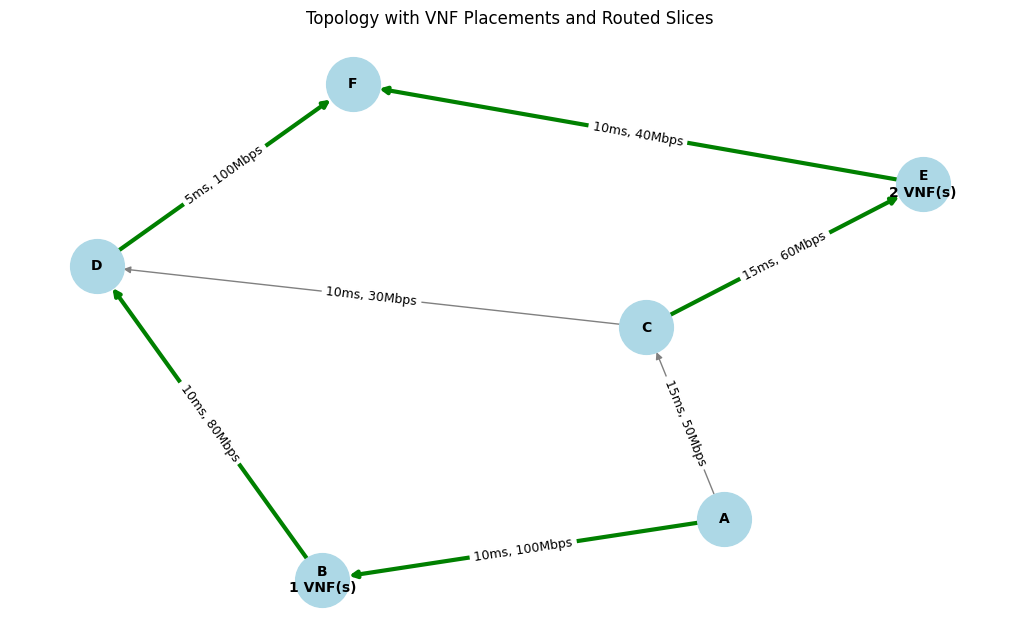

In [154]:
# Draw the graph showing VNF placements on nodes

# Determine node labels with VNF counts
node_labels = {}
for node in G.nodes:
    vnf_count = vnf_allocations[node]
    label = f"{node}\n{vnf_count} VNF(s)" if vnf_count > 0 else node
    node_labels[node] = label

# Redefine edge colors to highlight only successful paths
edge_colors = []
edge_widths = []
highlighted_edges = set()

# Collect all used paths
for result in allocation_results:
    if result['Path'] and result['SLA Met']:
        highlighted_edges.update(zip(result['Path'], result['Path'][1:]))

for u, v in G.edges():
    if (u, v) in highlighted_edges:
        edge_colors.append('green')
        edge_widths.append(3)
    else:
        edge_colors.append('gray')
        edge_widths.append(1)

# Draw the graph with updated labels and path highlights
plt.figure(figsize=(10, 6))
nx.draw(G, pos, labels=node_labels, with_labels=True, node_color='lightblue',
        node_size=1500, edge_color=edge_colors, width=edge_widths,
        font_size=10, font_weight='bold')

# Annotate edges with latency and capacity
edge_labels = {(u, v): f"{G[u][v]['latency']}ms, {G[u][v]['capacity']}Mbps" for u, v in G.edges()}
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='black', font_size=9)

plt.title("Topology with VNF Placements and Routed Slices")
plt.axis('off')
plt.tight_layout()
plt.show()


In [155]:
# Energy parameters
E_base_node = 10  # Base energy (Watts) for active node
E_per_vnf = 5     # Energy per VNF (Watts)
alpha_link = 0.5  # Energy per unit latency on link (Watts/ms)

# Compute energy for each accepted slice
for result in allocation_results:
    if result['Path'] and result['SLA Met'] and result['VNF Placement']:
        # Node energy: base + VNF energy
        used_nodes = set(result['VNF Placement'])
        node_energy = sum(E_base_node + E_per_vnf * vnf_allocations[node] for node in used_nodes)

        # Link energy: sum over latencies in the path
        link_energy = sum(G[u][v]['latency'] * alpha_link for u, v in zip(result['Path'], result['Path'][1:]))

        # Total energy
        result['Node Energy (W)'] = node_energy
        result['Link Energy (W)'] = link_energy
        result['Total Energy (W)'] = node_energy + link_energy
    else:
        result['Node Energy (W)'] = None
        result['Link Energy (W)'] = None
        result['Total Energy (W)'] = None

# Create updated DataFrame with energy metrics
energy_df = pd.DataFrame(allocation_results)
energy_df[['Slice ID', 'Path', 'VNF Placement', 'Node Energy (W)', 'Link Energy (W)', 'Total Energy (W)']]


,Slice ID,Path,VNF Placement,Node Energy (W),Link Energy (W),Total Energy (W)
0,1,"[A, B, D, F]",[B],15.0,12.5,27.5
1,2,None,None,NaN,NaN,NaN
2,3,None,None,NaN,NaN,NaN
3,4,"[C, E, F]","[E, E]",20.0,12.5,32.5
4,5,None,None,NaN,NaN,NaN


In [156]:
# Reset VNF capacity and allocation on nodes
vnf_capacity_per_node = {node: 2 for node in G.nodes}  # max 2 VNFs per node
vnf_allocations = {node: 0 for node in G.nodes}        # reset allocation count

# Define function to simulate First Fit for all slices
def simulate_first_fit(graph, slice_requests):
    results = []

    for idx, request in enumerate(slice_requests):
        source = request['source']
        target = request['target']
        sla_latency_max = request['sla_latency']
        sla_min_capacity = request['sla_capacity']
        num_vnfs = request['num_vnfs']

        # Attempt to route the slice
        path, latency = astar_with_sla(graph, source, target, sla_min_capacity, sla_latency_max)
        if path:
            # Attempt to allocate VNFs on the path (excluding source)
            vnf_nodes = allocate_vnfs_on_path(path[1:], num_vnfs)
            if vnf_nodes:
                # Calculate energy
                used_nodes = set(vnf_nodes)
                node_energy = sum(E_base_node + E_per_vnf * vnf_allocations[node] for node in used_nodes)
                link_energy = sum(G[u][v]['latency'] * alpha_link for u, v in zip(path, path[1:]))

                results.append({
                    'Slice ID': idx + 1,
                    'Source': source,
                    'Target': target,
                    'Path': path,
                    'VNFs Required': num_vnfs,
                    'VNF Placement': vnf_nodes,
                    'Total Latency (ms)': latency,
                    'Node Energy (W)': node_energy,
                    'Link Energy (W)': link_energy,
                    'Total Energy (W)': node_energy + link_energy,
                    'SLA Met': True
                })
            else:
                results.append({
                    'Slice ID': idx + 1,
                    'Source': source,
                    'Target': target,
                    'Path': path,
                    'VNFs Required': num_vnfs,
                    'VNF Placement': None,
                    'Total Latency (ms)': latency,
                    'Node Energy (W)': None,
                    'Link Energy (W)': None,
                    'Total Energy (W)': None,
                    'SLA Met': False
                })
        else:
            results.append({
                'Slice ID': idx + 1,
                'Source': source,
                'Target': target,
                'Path': None,
                'VNFs Required': num_vnfs,
                'VNF Placement': None,
                'Total Latency (ms)': None,
                'Node Energy (W)': None,
                'Link Energy (W)': None,
                'Total Energy (W)': None,
                'SLA Met': False
            })

    return pd.DataFrame(results)

# Run First Fit simulation
first_fit_df = simulate_first_fit(G, slice_requests)
first_fit_df[['Slice ID', 'Path', 'VNF Placement', 'Total Energy (W)', 'SLA Met']]


,Slice ID,Path,VNF Placement,Total Energy (W),SLA Met
0,1,"[A, B, D, F]",[B],27.5,True
1,2,None,None,NaN,False
2,3,None,None,NaN,False
3,4,"[C, E, F]","[E, E]",32.5,True
4,5,None,None,NaN,False


In [157]:
import networkx as nx
import random
import copy
from routing_a_star import astar_with_sla
from placement_first_fit import allocate_vnfs_first_fit

# --- Build topology ---
G = nx.DiGraph()
nodes = ['A', 'B', 'C', 'D', 'E', 'F']
G.add_nodes_from(nodes)
edges = [
    ('A', 'B', {'latency': 10, 'capacity': 100}),
    ('A', 'C', {'latency': 15, 'capacity': 50}),
    ('B', 'D', {'latency': 10, 'capacity': 80}),
    ('C', 'D', {'latency': 10, 'capacity': 30}),
    ('C', 'E', {'latency': 15, 'capacity': 60}),
    ('D', 'F', {'latency': 5, 'capacity': 100}),
    ('E', 'F', {'latency': 10, 'capacity': 40})
]
G.add_edges_from(edges)

node_capacity = {node: 3 for node in G.nodes}
node_capacity_copy = copy.deepcopy(node_capacity)

# --- Slice requests ---
slices = [
    {'id': 1, 'source': 'A', 'target': 'F', 'latency': 40, 'capacity': 50, 'vnfs': 3},
    {'id': 2, 'source': 'C', 'target': 'F', 'latency': 20, 'capacity': 60, 'vnfs': 2},
    {'id': 3, 'source': 'B', 'target': 'F', 'latency': 25, 'capacity': 90, 'vnfs': 2},
    {'id': 4, 'source': 'C', 'target': 'F', 'latency': 50, 'capacity': 30, 'vnfs': 1},
    {'id': 5, 'source': 'B', 'target': 'F', 'latency': 35, 'capacity': 100, 'vnfs': 3}
]

node_energy = 10
link_energy = 5
results = []

# --- Process slices ---
for s in slices:
    path, total_latency = astar_with_sla(G, s['source'], s['target'], s['capacity'], s['latency'])
    if path:
        vnfs_allocated = allocate_vnfs_first_fit(path, s['vnfs'], node_capacity_copy)
        if vnfs_allocated:
            used_links = [(path[i], path[i + 1]) for i in range(len(path) - 1)]
            energy = len(set(vnfs_allocated)) * node_energy + len(used_links) * link_energy
            results.append((s['id'], path, vnfs_allocated, energy, "SLA OK"))
        else:
            results.append((s['id'], path, None, None, "VNF Allocation Failed"))
    else:
        results.append((s['id'], None, None, None, "No SLA Path Found"))

# --- Show results ---
for r in results:
    print(f"Slice {r[0]}: Path = {r[1]}, VNFs = {r[2]}, Energy = {r[3]}, Status = {r[4]}")


Slice 1: Path = ['A', 'B', 'D', 'F'], VNFs = ['A', 'B', 'D'], Energy = 45, Status = SLA OK
Slice 2: Path = None, VNFs = None, Energy = None, Status = No SLA Path Found
Slice 3: Path = None, VNFs = None, Energy = None, Status = No SLA Path Found
Slice 4: Path = ['C', 'D', 'F'], VNFs = ['C'], Energy = 20, Status = SLA OK
Slice 5: Path = None, VNFs = None, Energy = None, Status = No SLA Path Found
